In [1]:
import sys, os, pickle, time, json, yaml, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd
import root_numpy as rtnp
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import chi2 as scipy_chi2

Welcome to JupyROOT 6.12/07


In [2]:
candDir='ntuples_B2DstMu_mediumId'
skimmedTag=''
MCsample = {
######## Signals
'tau': DSetLoader('Bd_TauNuDst', candDir=candDir, skimmedTag=skimmedTag),
'mu': DSetLoader('Bd_MuNuDst', candDir=candDir, skimmedTag=skimmedTag),
######## D** background
'Bu_MuDstPi': DSetLoader('Bu_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_MuDstPi': DSetLoader('Bd_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
# 'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi', candDir=candDir, skimmedTag=args.skimmedTag),
'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi_v2', candDir=candDir, skimmedTag=skimmedTag),
'Bu_MuDstPiPi': DSetLoader('Bu_MuNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPi': DSetLoader('Bu_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPi': DSetLoader('Bd_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPiPi': DSetLoader('Bd_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPiPi': DSetLoader('Bu_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bs_MuDstK': DSetLoader('Bs_MuNuDstK', candDir=candDir, skimmedTag=skimmedTag),
'Bs_TauDstK': DSetLoader('Bs_TauNuDstK', candDir=candDir, skimmedTag=skimmedTag),
######## D*Hc background
'Bd_DstDu': DSetLoader('Bd_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDu': DSetLoader('Bu_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDd': DSetLoader('Bd_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDd': DSetLoader('Bu_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDs': DSetLoader('Bd_DstDs', candDir=candDir, skimmedTag=skimmedTag),
'Bs_DstDs': DSetLoader('Bs_DstDs', candDir=candDir, skimmedTag=skimmedTag),
}

In [3]:
branches = ['MC_tkFlag_0', 'MC_tkFlag_1',
            'MC_tkFromMainB_0', 'MC_tkFromMainB_1',
            'MC_tk_dpt_0', 'MC_tk_dpt_1',
            'MC_tk_deta_0', 'MC_tk_deta_1',
            'MC_tk_dphi_0', 'MC_tk_dphi_1',
            'MC_tkPdgId_0', 'MC_tkPdgId_1',
            'MC_tkMotherPdgId_0', 'MC_tkMotherPdgId_1']

table = PrettyTable()
table.field_names = ['Sample', '0', '1 [1e-3]', '2 [1e-6]']

effData = []
allMothersPdgId = []
for k, s in MCsample.iteritems():
    print k
    nSigReg = 0
    with open(s.skimmed_dir + '/High_bare.log', 'r') as f:
        nSigReg += int( f.readlines()[-2][:-1].split(' ')[-1] )
    df = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/High_trkCtrl_bare.root', branches=branches))
    
    sel_tk0 = np.array(np.logical_and(df['MC_tkFlag_0'] == 1, df['MC_tkFromMainB_0'] == 0).astype(np.int))
    sel_tk1 = np.array(np.logical_and(df['MC_tkFlag_1'] == 1, df['MC_tkFromMainB_1'] == 0).astype(np.int))
    trkCounts = Counter(sel_tk0 + sel_tk1)
    trkCounts[0] += nSigReg
    tot = np.sum([x for x in trkCounts.values()])
    
    table.add_row([k, 
                   '{:.5f} +/- {:.5f}'.format(*np.array(getEff(trkCounts[0], tot))),
                   '{:.3f} +/- {:.3f}'.format(*(1e3*np.array(getEff(trkCounts[1], tot)))),
                   '{:.3f} +/- {:.3f}'.format(*(1e6*np.array(getEff(trkCounts[2], tot))))
                  ])
    
    effData.append([k] + list(1e3*np.array(getEff(trkCounts[1], tot))) )
    
    mothersId = np.concatenate((np.array(df['MC_tkMotherPdgId_0'][sel_tk0.astype(np.bool)]),
                                np.array(df['MC_tkMotherPdgId_1'][sel_tk1.astype(np.bool)])
                               ))
    mothersId = np.abs(np.array(mothersId).astype(np.int))
    print 'Tracks MC mother pdgId:'
    print np.sort(np.unique(mothersId))
    allMothersPdgId += list(np.unique(mothersId))
    
    print '----------\n'
    
    
print '\nAll mothers pdgId:'
allMothersPdgId = np.sort(np.unique(allMothersPdgId))
print allMothersPdgId

Bd_MuDstPiPi
Tracks MC mother pdgId:
[   1    2    3    4    5   21  333  431  521 2212]
----------

tau
Tracks MC mother pdgId:
[    1     2     3     4     5    21   113   213   223   313   323   331
   333   413   421   511   521  2212  2214  4122  4124  5122 20213]
----------

Bs_DstDs
Tracks MC mother pdgId:
[   1    2    3    4    5  113  333  421 2212]
----------

Bd_TauDstPi
Tracks MC mother pdgId:
[   2    3    5  213  221 2212]
----------

Bu_MuDstPiPi
Tracks MC mother pdgId:
[   1    2    3    4    5   21  113  213  221  223  313  411  421  511
 2212 5132]
----------

Bs_MuDstK
Tracks MC mother pdgId:
[   1    2    3    4    5   15   21  111  113  213  221  313  323  331
  333  411  413  421  431  511  521  541 1114 2212 5132]
----------

Bd_MuDstPi
Tracks MC mother pdgId:
[   1    2    3    4    5   21  111  113  213  221  223  313  323  331
  333  411  413  421  431  443  511  521  531  541 2212 2214]
----------

Bu_TauDstPi
Tracks MC mother pdgId:
[   1    5 2212]
-------

In [4]:
print table

+---------------+---------------------+-----------------+---------------------+
|     Sample    |          0          |     1 [1e-3]    |       2 [1e-6]      |
+---------------+---------------------+-----------------+---------------------+
|  Bd_MuDstPiPi | 0.99411 +/- 0.00036 | 5.863 +/- 0.360 |  22.294 +/- 22.294  |
|      tau      | 0.99447 +/- 0.00016 | 5.409 +/- 0.159 |  116.879 +/- 23.374 |
|    Bs_DstDs   | 0.99473 +/- 0.00063 | 5.266 +/- 0.628 |   0.000 +/- 0.000   |
|  Bd_TauDstPi  | 0.99434 +/- 0.00097 | 5.489 +/- 0.953 | 166.334 +/- 166.320 |
|  Bu_MuDstPiPi | 0.99366 +/- 0.00036 | 6.339 +/- 0.359 |   0.000 +/- 0.000   |
|   Bs_MuDstK   | 0.99258 +/- 0.00023 | 7.214 +/- 0.225 |  204.313 +/- 37.936 |
|   Bd_MuDstPi  | 0.99314 +/- 0.00014 | 6.739 +/- 0.143 |  116.504 +/- 18.898 |
|  Bu_TauDstPi  | 0.99405 +/- 0.00096 | 5.946 +/- 0.962 |   0.000 +/- 0.000   |
|    Bd_DstDd   | 0.99530 +/- 0.00038 | 4.674 +/- 0.381 |  31.158 +/- 31.157  |
|    Bu_DstDu   | 0.99541 +/- 0.00021 | 

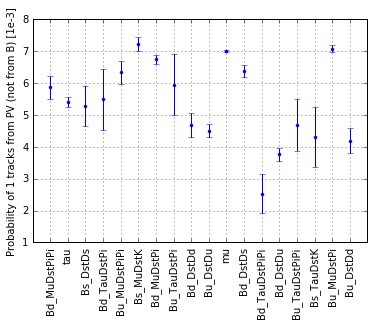

In [5]:
effData=np.array(effData)
plt.errorbar(np.arange(len(effData)), effData[:,1].astype(np.float), yerr=effData[:,2].astype(np.float), fmt='.')

plt.xlim(-1, len(effData))
plt.gca().set_xticks(np.arange(-1,len(effData)))
plt.gca().set_xticklabels([''] + list(effData[:,0]))
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Probability of 1 tracks from PV (not from B) [1e-3]')

# Breakdown by mother type

In [29]:
def plotSelectionForMother(selFun, tag=''):
    effData = []
    for k, s in MCsample.iteritems():
        nSigReg = 0
        with open(s.skimmed_dir + '/High_bare.log', 'r') as f:
            nSigReg += int( f.readlines()[-2][:-1].split(' ')[-1] )
        df = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/High_trkCtrl_bare.root', branches=branches))

        sel_tk0 = np.logical_and(df['MC_tkFlag_0'] == 1, df['MC_tkFromMainB_0'] == 0)
        sel_tk1 = np.logical_and(df['MC_tkFlag_1'] == 1, df['MC_tkFromMainB_1'] == 0)

        # mother selection
        sel_tk0 = np.logical_and(sel_tk0, selFun(df['MC_tkMotherPdgId_0']))
        sel_tk1 = np.logical_and(sel_tk1, selFun(df['MC_tkMotherPdgId_1']))
        
        sel_tk0 = np.array(sel_tk0).astype(np.int)
        sel_tk1 = np.array(sel_tk1).astype(np.int)

        trkCounts = Counter(sel_tk0 + sel_tk1)
        trkCounts[0] += nSigReg
        tot = np.sum([x for x in trkCounts.values()])

        effData.append([k] + list(1e3*np.array(getEff(trkCounts[1], tot))) )
    effData=np.array(effData)
    y = effData[:,1].astype(np.float)
    yerr=effData[:,2].astype(np.float)
    
    plt.figure(figsize=(6, 4))
    plt.errorbar(np.arange(len(effData)), y, yerr=yerr, fmt='.')

    plt.xlim(-1, len(effData))
    plt.gca().set_xticks(np.arange(-1,len(effData)))
    plt.gca().set_xticklabels([''] + list(effData[:,0]))
    plt.xticks(rotation=90)
    plt.grid()
    plt.ylabel('Probability [1e-3]')
    plt.title('Events with 1 track from PV (not from B)' + tag)
    
    if np.min(y) > 0:
        avg, avgErr = np.polyfit(np.arange(len(effData)), y, 0, w=1./yerr, cov=True)
        avg = avg[0]
        avgErr = avgErr[0][0]
        plt.fill_between([-1, len(effData)], 2*[avg-avgErr], 2*[avg+avgErr], color='salmon')    
        chi2 = np.sum(np.square( (y-avg)/yerr ))
        dof = y.shape[0] - 1
        pval = scipy_chi2.sf(chi2, dof)
        text = 'Chi2 = {:.1f}/{:.0f} ({:.1f}%)'.format(chi2, dof, 100*pval)
        plt.plot([-1, len(effData)], 2*[avg], '--', color='red', label=text)
        plt.legend(loc='best')

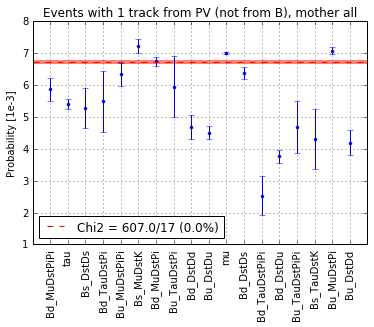

In [30]:
plotSelectionForMother(lambda x: np.ones_like(x).astype(np.bool), ', mother all')

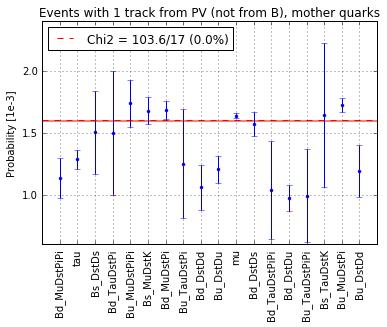

In [7]:
plotSelectionForMother(lambda x: x <= 5, ', mother quarks')

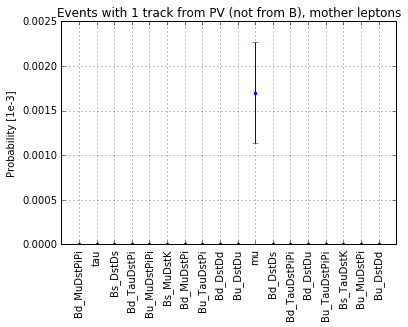

In [8]:
plotSelectionForMother(lambda x: np.logical_and(x >= 10, x<=20), ', mother leptons')

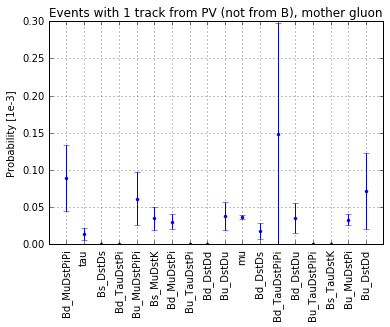

In [9]:
plotSelectionForMother(lambda x: x==21, ', mother gluon')

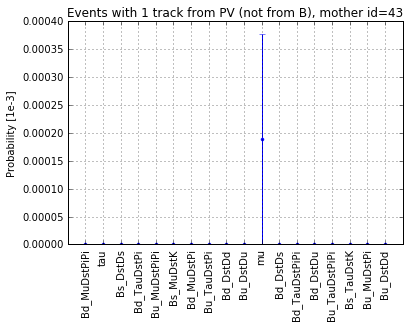

In [10]:
plotSelectionForMother(lambda x: x==43, ', mother id=43')

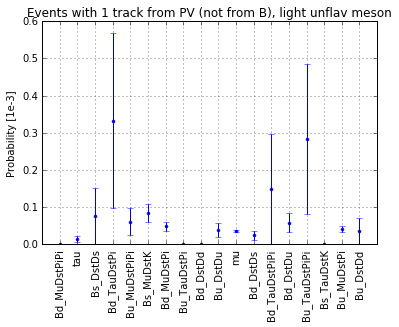

In [16]:
def sel(x):
    xRed = np.mod(x, 10000)
    return np.logical_and(xRed >= 100, xRed < 300 )
plotSelectionForMother(sel, ', light unflav meson')

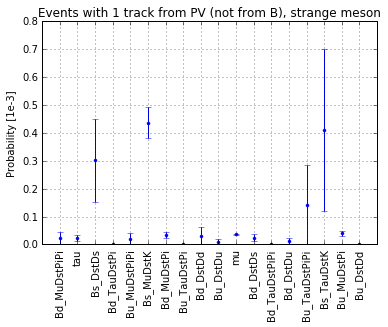

In [17]:
def sel(x):
    xRed = np.mod(x, 10000)
    return np.logical_and(xRed >= 300, xRed < 400 )
plotSelectionForMother(sel, ', strange meson')

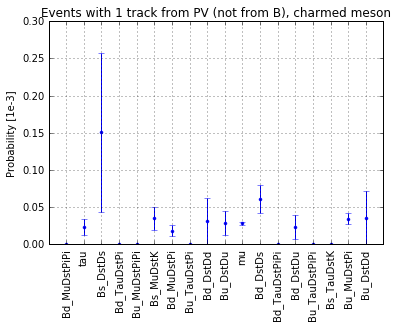

In [18]:
def sel(x):
    xRed = np.mod(x, 10000)
    return np.logical_and(xRed >= 400, xRed < 500 )
plotSelectionForMother(sel, ', charmed meson')

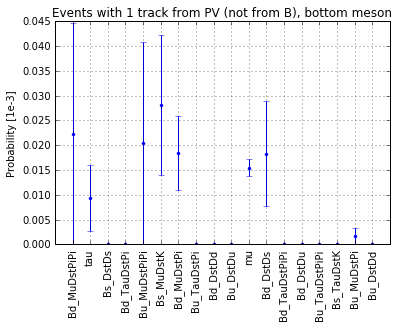

In [19]:
def sel(x):
    xRed = np.mod(x, 10000)
    return np.logical_and(xRed >= 500, xRed < 600 )
plotSelectionForMother(sel, ', bottom meson')

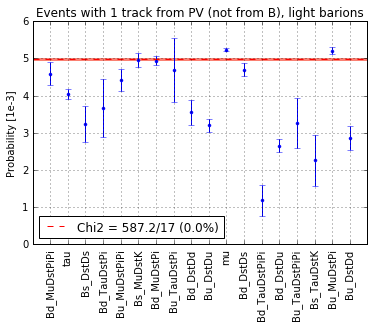

In [21]:
plotSelectionForMother(lambda x: np.logical_and(np.mod(x, 10000) > 1000, np.mod(x, 10000) < 3000) ,
                       ', light barions')